In [1]:
# 1) get the model from trained ATTITUDE_STARLINK

In [92]:
# just using the bounding box
#### get png and json filepaths

import glob
import os
import re
from PIL import Image

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random10k_FORFILTERING/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)

## get the translations (YVALS) from the json files

import os
import json
import numpy as np

translations = []
for json_f in json_files:
    with open(json_f) as f: translations.append(json.load(f)['attitude'])

translations = np.array(translations, dtype=np.float32)
y_vals = translations


# extract dimensions (XVALS) from the data
from skimage.color import rgb2gray
def model_dimensions(img_np:np.ndarray):

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    try:
        ymin, ymax = np.min(y), np.max(y)
        xmin, xmax = np.min(x), np.max(x)
    except:
        ymin, ymax = 0, 0
        xmin, xmax = 0, 0
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = horiz_sums[horiz_sums>0.01]
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = vert_sums[vert_sums>0.01]
    vert_sums = [i for i in vert_sums]

    # turn the horizontal and vertical sums into a spline, and sample 20 points
    from scipy.interpolate import UnivariateSpline
    horiz_spline = UnivariateSpline(range(len(horiz_sums)), horiz_sums)
    vert_spline = UnivariateSpline(range(len(vert_sums)), vert_sums)
    horiz_spline.set_smoothing_factor(0.5)
    vert_spline.set_smoothing_factor(0.5)

    values_to_query = np.linspace(0, len(horiz_sums), 50)
    horiz_spline_vals = horiz_spline(values_to_query)

    values_to_query = np.linspace(0, len(vert_sums), 50)
    vert_spline_vals  = vert_spline(values_to_query)

    return [height, width] + list(horiz_spline_vals) + list(vert_spline_vals)


import tqdm
dimensions = []
for png_f in tqdm.tqdm(png_files, desc='loading x vals'):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))
dimensions = np.array(dimensions, dtype=np.float32)
xvals = dimensions


# # convert quaternions to euler angles
# import math
# def euler_from_quaternion(quaternion_inp):
#         """
#         Convert a quaternion into euler angles (roll, pitch, yaw)
#         roll is rotation around x in radians (counterclockwise)
#         pitch is rotation around y in radians (counterclockwise)
#         yaw is rotation around z in radians (counterclockwise)
#         """
#         x, y, z, w = quaternion_inp
#         t0 = +2.0 * (w * x + y * z)
#         t1 = +1.0 - 2.0 * (x * x + y * y)
#         roll_x = math.atan2(t0, t1)
     
#         t2 = +2.0 * (w * y - z * x)
#         t2 = +1.0 if t2 > +1.0 else t2
#         t2 = -1.0 if t2 < -1.0 else t2
#         pitch_y = math.asin(t2)
     
#         t3 = +2.0 * (w * z + x * y)
#         t4 = +1.0 - 2.0 * (y * y + z * z)
#         yaw_z = math.atan2(t3, t4)
     
#         return roll_x, pitch_y, yaw_z # in radians

# y_vals_euler = []
# for i in range(len(y_vals)):
#     y_vals_euler.append(euler_from_quaternion(y_vals[i]))

# y_vals_euler = np.array(y_vals_euler, dtype=np.float32)
# y_vals = y_vals_euler


# x_vals = [:,:2]
# y_vals = [:,:2]

loading x vals: 100%|██████████| 10000/10000 [01:30<00:00, 110.59it/s]


In [93]:

# CHOOSE TRAINING AND TESTING INDICES

import random
random.seed(42)
data_percent = 0.7
n_pts_to_train = int(data_percent*len(xvals))

indices = list(range(len(xvals)))
random.shuffle(indices)
train_indices = indices[:n_pts_to_train]
test_indices = indices[n_pts_to_train:]
print(len(train_indices), len(test_indices))


7000 3000


geodesic distance, radians on test Extra trees 0.146480337139484
geodesic distance, radians on test K-nn 0.2227891
geodesic distance, radians on test Ridge 0.2118932195179741
geodesic distance, radians on test Linear Regression 0.2852952
geodesic distance, radians on test Lasso Linear_0.01 0.24213399
geodesic distance, radians on test Lasso Linear_0.1 0.3335835
geodesic distance, radians on test Lasso Linear_0.5 0.3399109


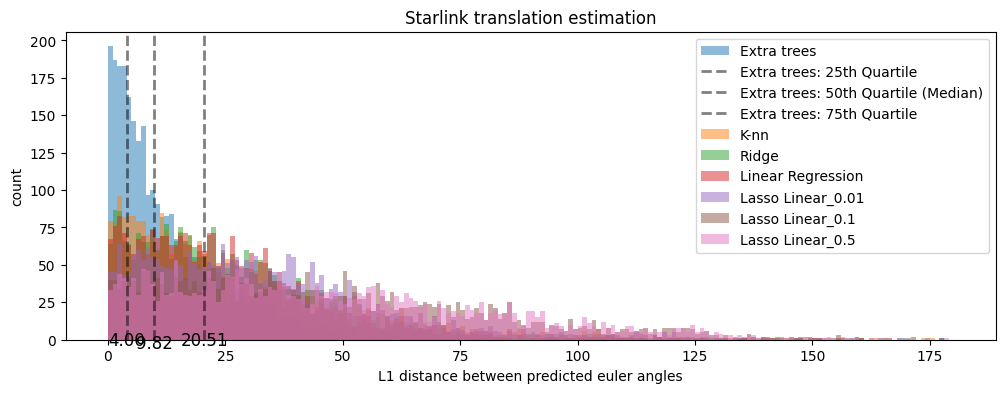

In [94]:

# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import sklearn
import matplotlib.pyplot as plt

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}


def geodesic_rot_distance(target, pred):
    return np.linalg.norm(target-pred, axis=-1, ord=1)

########## DEFINE BINS

# Define the desired bin edges (minimum and maximum values)
min_bin = 0
max_bin = 180
bin_width = 1  # Adjust this value as needed

# Calculate the number of bins based on the range and bin width
num_bins = int((max_bin - min_bin) / bin_width)

y_test_predict = dict()
plt.figure(figsize=(12, 4))
for name, estimator in ESTIMATORS.items():
    estimator.fit(xvals[train_indices], y_vals[train_indices])
    y_test_predict[name] = estimator.predict(xvals[test_indices])
    print(f'geodesic distance, radians on test {name}', sklearn.metrics.mean_squared_error(y_vals[test_indices], y_test_predict[name], squared=False))
    data = geodesic_rot_distance(y_vals[test_indices], y_test_predict[name])*180/np.pi
    plt.hist(data, bins=num_bins, range=(min_bin, max_bin), alpha=0.5, label=name)
    
    if name == 'Extra trees':
        # Calculate QUARTILES values
        q25 = np.percentile(data, 25)
        q50 = np.percentile(data, 50)
        q75 = np.percentile(data, 75)

        # Add vertical lines for quartiles
        plt.axvline(q25, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Extra trees: 25th Quartile')
        plt.axvline(q50, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Extra trees: 50th Quartile (Median)')
        plt.axvline(q75, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Extra trees: 75th Quartile')
        
        plt.text(q25, -4, f'{q25:.2f}', color='black', fontsize=12, ha='center')
        plt.text(q50, -6, f'{q50:.2f}', color='black', fontsize=12, ha='center')
        plt.text(q75, -4, f'{q75:.2f}', color='black', fontsize=12, ha='center')

    plt.title('Starlink translation estimation')
    plt.xlabel('L1 distance between predicted euler angles')
    plt.ylabel('count')
    plt.legend()
    # plt.show()


In [10]:
# using this MODEL (the best one); predict TRANSLATIONS on the sequential data

In [99]:
def load_data(path:str="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_sequence1/data", attribute='pose', spline:bool = False):
    # LOAD THE SEQUENTIAL DATA

    # just using the bounding box
    #### get png and json filepaths

    import glob
    import os
    import re
    from PIL import Image

    png_files = glob.glob(os.path.join(path, '*.png'))
    json_files = glob.glob(os.path.join(path, '*.json'))

    def extract_png_number(filename):
        match = re.search(r'(\d+).png$', filename)
        if match:   return int(match.group(1))
        else:       return -1
        
    def extract_json_number(filename):
        match = re.search(r'(\d+).json$', filename)
        if match:   return int(match.group(1))
        else:       return -1

    png_files.sort(key=extract_png_number)
    json_files.sort(key=extract_json_number)

    ## get the translations (YVALS) from the json files

    import os
    import json
    import numpy as np

    translations = []
    for json_f in json_files:
        with open(json_f) as f: translations.append(json.load(f)[attribute])

    translations = np.array(translations, dtype=np.float32)
    y_vals = translations


    # extract dimensions (XVALS) from the data
    from skimage.color import rgb2gray
    def model_dimensions(img_np:np.ndarray):

        # create object mask
        img_np_copy = img_np.copy()
        img_np_copy[np.where(img_np_copy<0.01)] = 0
        img_np_copy[np.where(img_np_copy>0.01)] = 1

        # determine object dimensions
        y,x,c = np.where(img_np_copy>0)
        try:
            ymin, ymax = np.min(y), np.max(y)
            xmin, xmax = np.min(x), np.max(x)
        except:
            ymin, ymax = 0, 0
            xmin, xmax = 0, 0
        height = ymax - ymin
        width = xmax - xmin

        # determine horizontal-wise pixel sums
        img_np_copy_bw = rgb2gray(img_np_copy.copy())
        horiz_sums = np.sum(img_np_copy_bw, axis=0)
        horiz_sums = horiz_sums/np.max(horiz_sums)
        horiz_sums = horiz_sums[horiz_sums>0.01]
        horiz_sums = [i for i in horiz_sums]

        # determine vertical-wise pixel sums
        vert_sums = np.sum(img_np_copy_bw, axis=1)
        vert_sums = vert_sums/np.max(vert_sums)
        vert_sums = vert_sums[vert_sums>0.01]
        vert_sums = [i for i in vert_sums]

        # turn the horizontal and vertical sums into a spline, and sample 20 points
        from scipy.interpolate import UnivariateSpline
        horiz_spline = UnivariateSpline(range(len(horiz_sums)), horiz_sums)
        vert_spline = UnivariateSpline(range(len(vert_sums)), vert_sums)
        horiz_spline.set_smoothing_factor(0.5)
        vert_spline.set_smoothing_factor(0.5)

        values_to_query = np.linspace(0, len(horiz_sums), 50)
        horiz_spline_vals = horiz_spline(values_to_query)

        values_to_query = np.linspace(0, len(vert_sums), 50)
        vert_spline_vals  = vert_spline(values_to_query)

        if not spline: return [height, width, ymin, ymax, xmin, xmax] 
        else:          return [height, width] + list(horiz_spline_vals) + list(vert_spline_vals)


    import tqdm
    dimensions = []
    for png_f in tqdm.tqdm(png_files, desc='loading x vals'):
        img = Image.open(png_f).convert('RGB')
        img_np = np.array(img)/255.0
        dimensions.append(model_dimensions(img_np))
    dimensions = np.array(dimensions, dtype=np.float32)
    xvals = dimensions
    return xvals, y_vals


In [100]:
xvals, yvals = load_data(path="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random10k_FORFILTERING/data", attribute='attitude', spline=True)
# y_vals_euler = []
# for i in range(len(yvals)):
#     y_vals_euler.append(euler_from_quaternion(yvals[i]))

# y_vals_euler = np.array(y_vals_euler, dtype=np.float32)
# y_vals = y_vals_euler

xvals_seq, y_vals_seq = load_data(path="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_sequence1_FORFILTERING/data", attribute='attitude', spline=True)

# y_vals_euler = []
# for i in range(len(y_vals_seq)):
#     y_vals_euler.append(euler_from_quaternion(y_vals_seq[i]))

# y_vals_euler = np.array(y_vals_euler, dtype=np.float32)
# y_vals_seq = y_vals_euler

loading x vals: 100%|██████████| 101/101 [00:01<00:00, 78.58it/s]


lp score on test, mlp [14.047909   3.6600661  3.7222335 ... 13.65507   17.97253    8.482333 ]


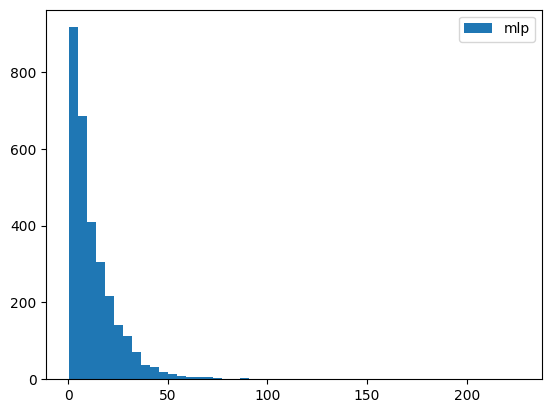

In [102]:
# and in using offsets?

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

x_vals = xvals
y_vals = yvals
scaler = StandardScaler()
scaler.fit(x_vals[train_indices])
x_train = scaler.transform(x_vals[train_indices])
x_test = scaler.transform(x_vals[test_indices])

clf = MLPRegressor([200, 200, 100], random_state=1, max_iter=500).fit(x_train, y_vals[train_indices])
y_pred = clf.predict(x_test)

# def lp(true, pred, p):
#     return np.linalg.norm(true - pred, axis=-1, ord=p)


# from pyquaternion import Quaternion
# def geodesic_rot_distance(target, pred):
#     distances = []
#     for i in range(len(target)):
#         distances.append(Quaternion.distance(Quaternion(target[i]), Quaternion(pred[i])))
#     return np.array(distances)
def geodesic_rot_distance(target, pred):
    return np.linalg.norm(target-pred, axis=-1, ord=1)


p = 1
name = 'mlp'
print(f'lp score on test, {name}', geodesic_rot_distance(y_vals[test_indices], y_pred)*180/np.pi)
plt.hist(geodesic_rot_distance(y_vals[test_indices], y_pred)*180/np.pi, bins=50, alpha=1, label=name);

# 


plt.legend()
plt.show()

ESTIMATORS['MLP'] = clf


loading x vals:   0%|          | 0/101 [00:00<?, ?it/s]

loading x vals: 100%|██████████| 101/101 [00:00<00:00, 103.29it/s]


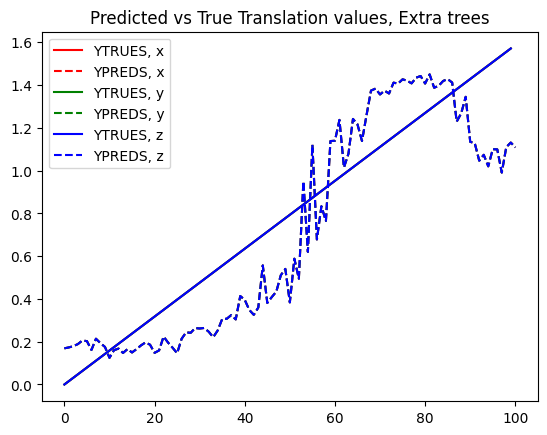

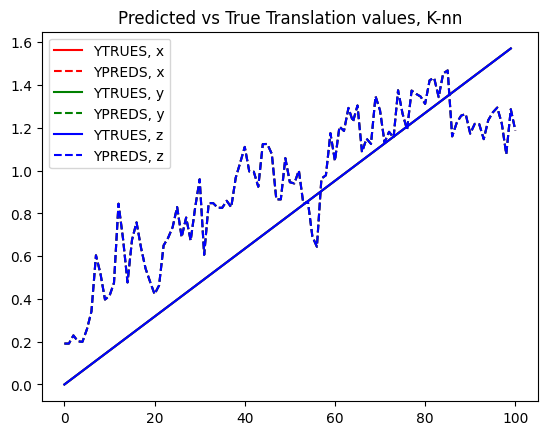

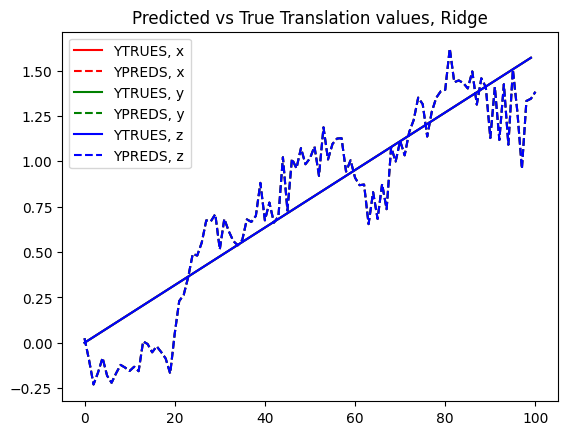

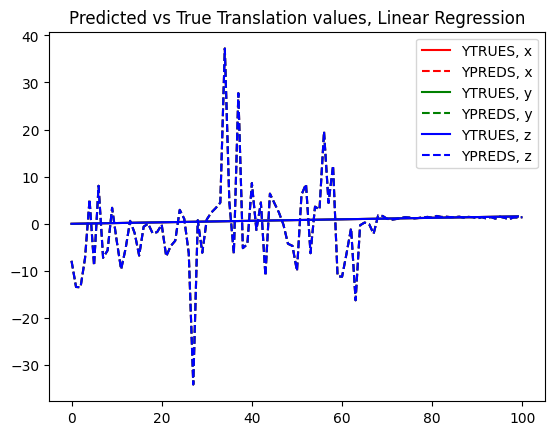

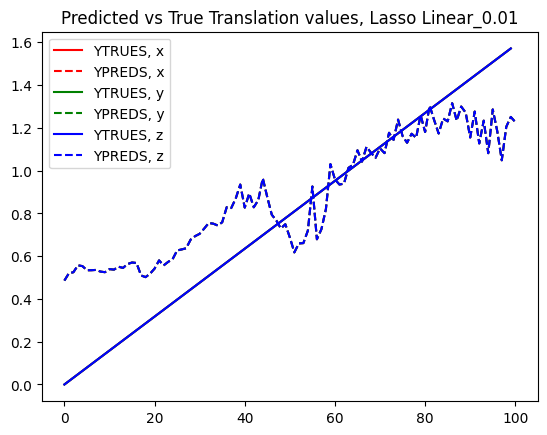

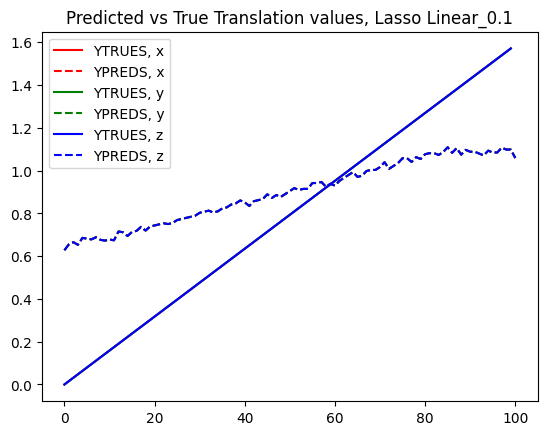

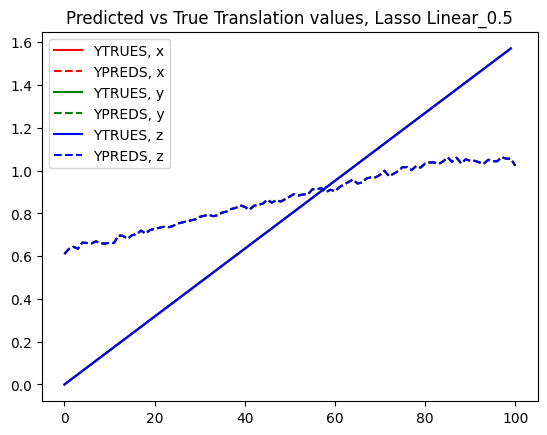

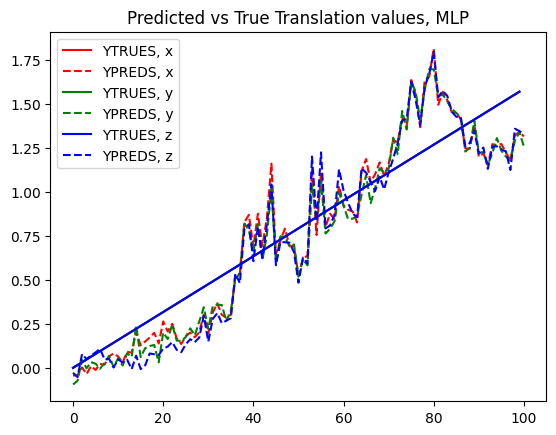

In [105]:
xvals_seq, y_vals_seq = load_data(path="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_sequence1_FORFILTERING1/data", attribute='attitude', spline=True)

for key in ESTIMATORS.keys():
    MODEL = ESTIMATORS[key]

    if key == 'MLP':
        # scaler = StandardScaler()
        YPREDS = MODEL.predict(scaler.transform(xvals_seq))
        YTRUES = y_vals_seq
    else:
        YPREDS = MODEL.predict(xvals_seq)
        YTRUES = y_vals_seq

    plt.title(f'Predicted vs True Translation values, {key}')
    plt.plot(YTRUES[:,0], label='YTRUES, x', color='red', linestyle='solid')
    plt.plot(YPREDS[:,0], label='YPREDS, x', color='red', linestyle='dashed')
    plt.plot(YTRUES[:,1], label='YTRUES, y', color='green', linestyle='solid')
    plt.plot(YPREDS[:,1], label='YPREDS, y', color='green', linestyle='dashed')
    plt.plot(YTRUES[:,2], label='YTRUES, z', color='blue', linestyle='solid')
    plt.plot(YPREDS[:,2], label='YPREDS, z', color='blue', linestyle='dashed')

    plt.legend()
    plt.show()


loading x vals: 100%|██████████| 101/101 [00:01<00:00, 76.30it/s]


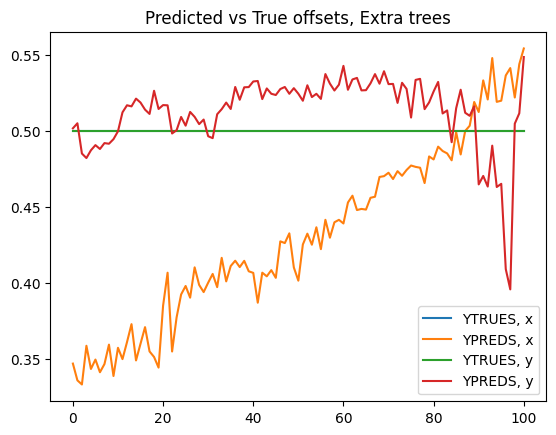

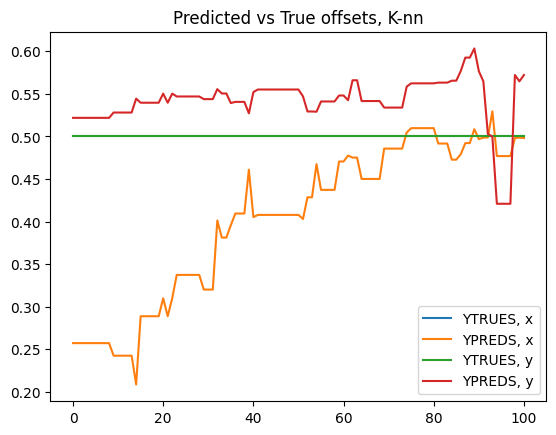

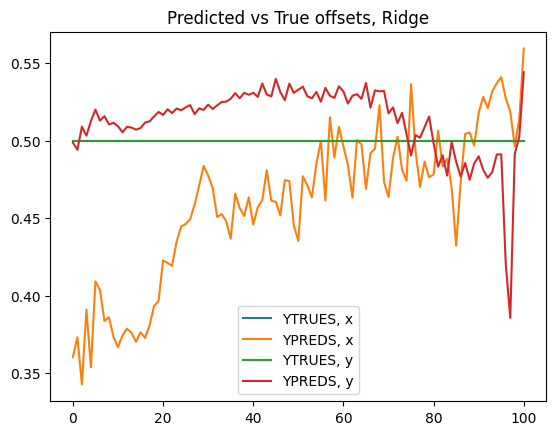

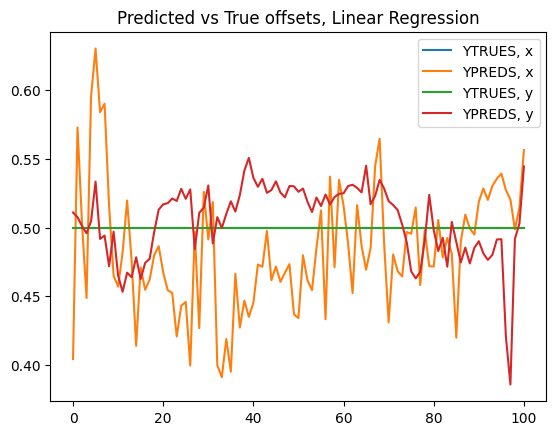

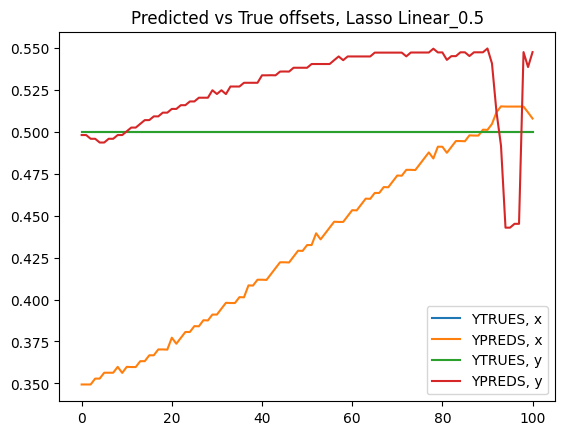

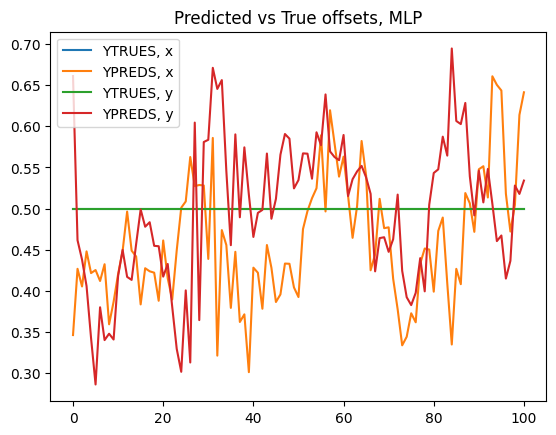

In [106]:

xvals_seq, y_vals_seq = load_data(path="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_sequence2/data", spline=True)

for key in ESTIMATORS.keys():
    MODEL = ESTIMATORS[key]

    if key == 'MLP':
        # scaler = StandardScaler()
        YPREDS = MODEL.predict(scaler.transform(xvals_seq))
        YTRUES = y_vals_seq
    else:
        YPREDS = MODEL.predict(xvals_seq)
        YTRUES = y_vals_seq
        min_bin = 0
        max_bin = 1

    plt.title(f'Predicted vs True offsets, {key}')
    plt.plot(YTRUES[:,0], label='YTRUES, x')
    plt.plot(YPREDS[:,0], label='YPREDS, x')
    plt.plot(YTRUES[:,1], label='YTRUES, y')
    plt.plot(YPREDS[:,1], label='YPREDS, y')

    plt.legend()
    plt.show()


loading x vals: 100%|██████████| 101/101 [00:00<00:00, 107.23it/s]


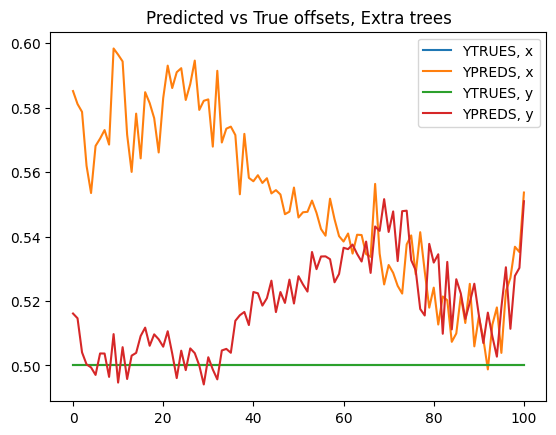

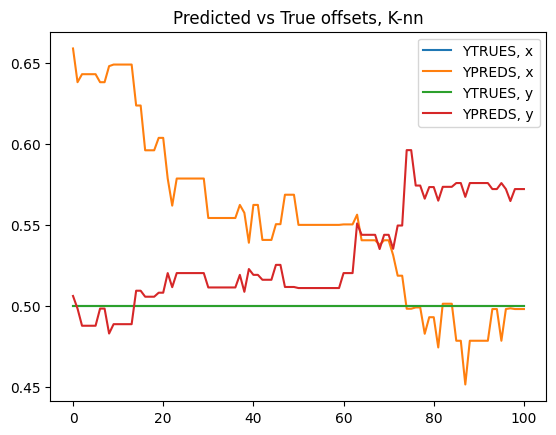

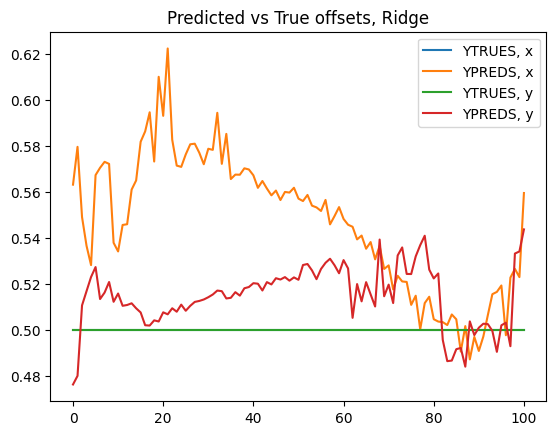

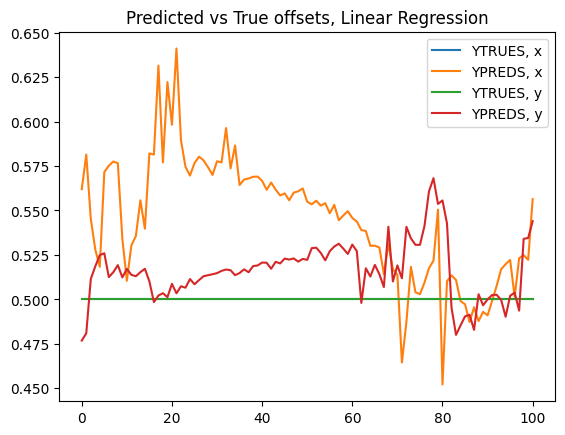

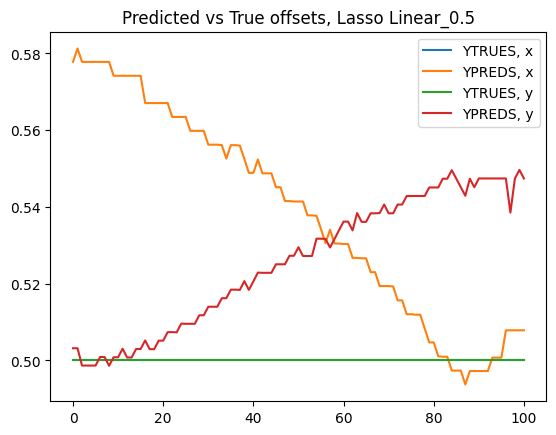

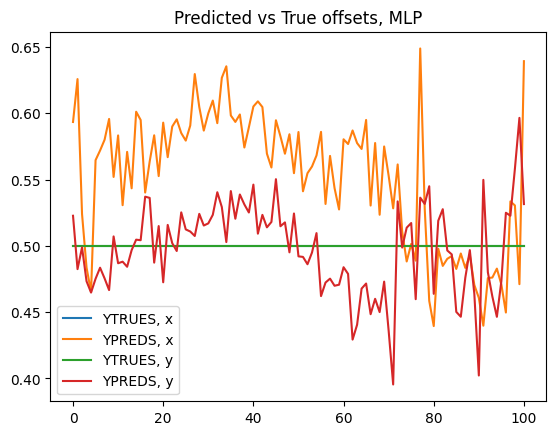

In [107]:

xvals_seq, y_vals_seq = load_data(path="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_sequence3/data", spline=True)

for key in ESTIMATORS.keys():
    MODEL = ESTIMATORS[key]

    if key == 'MLP':
        # scaler = StandardScaler()
        YPREDS = MODEL.predict(scaler.transform(xvals_seq))
        YTRUES = y_vals_seq
    else:
        YPREDS = MODEL.predict(xvals_seq)
        YTRUES = y_vals_seq
        min_bin = 0
        max_bin = 1

    plt.title(f'Predicted vs True offsets, {key}')
    plt.plot(YTRUES[:,0], label='YTRUES, x')
    plt.plot(YPREDS[:,0], label='YPREDS, x')
    plt.plot(YTRUES[:,1], label='YTRUES, y')
    plt.plot(YPREDS[:,1], label='YPREDS, y')

    plt.legend()
    plt.show()


In [108]:
# now adding filtering

loading x vals: 100%|██████████| 101/101 [00:01<00:00, 60.50it/s]


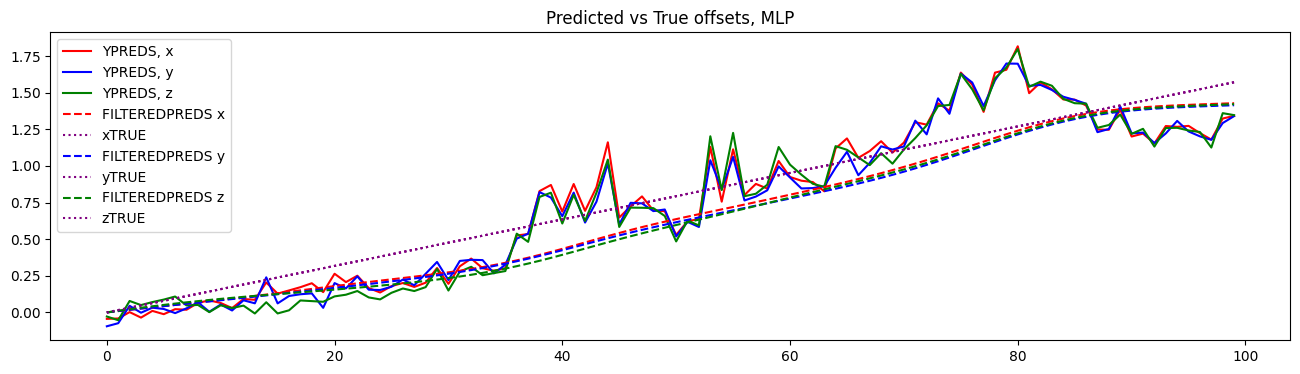

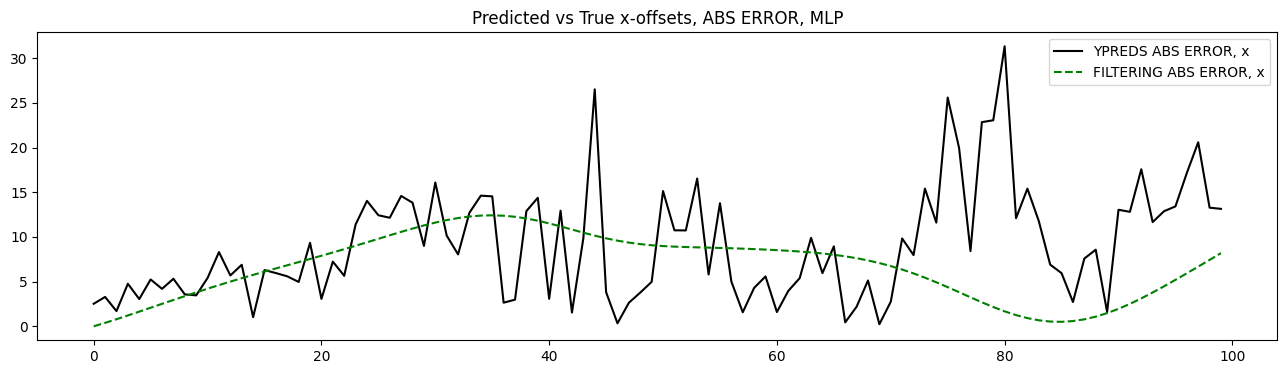

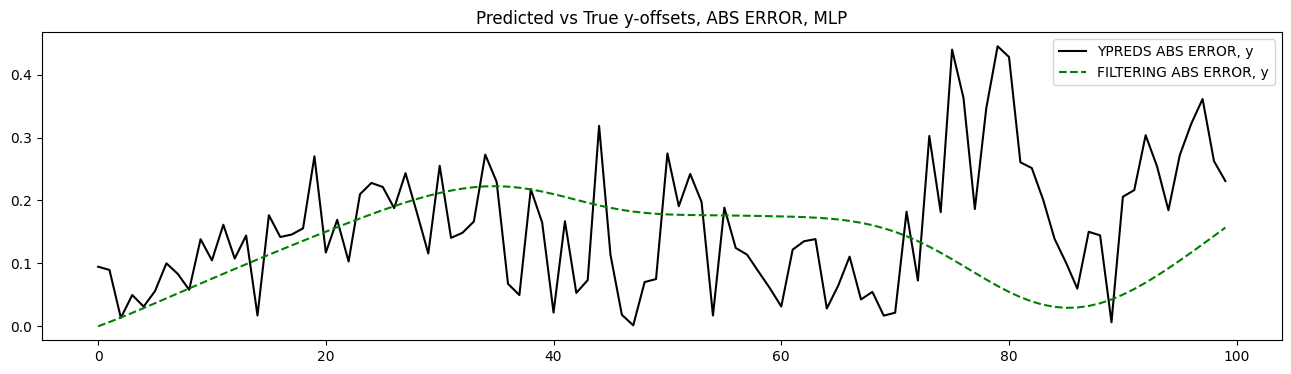

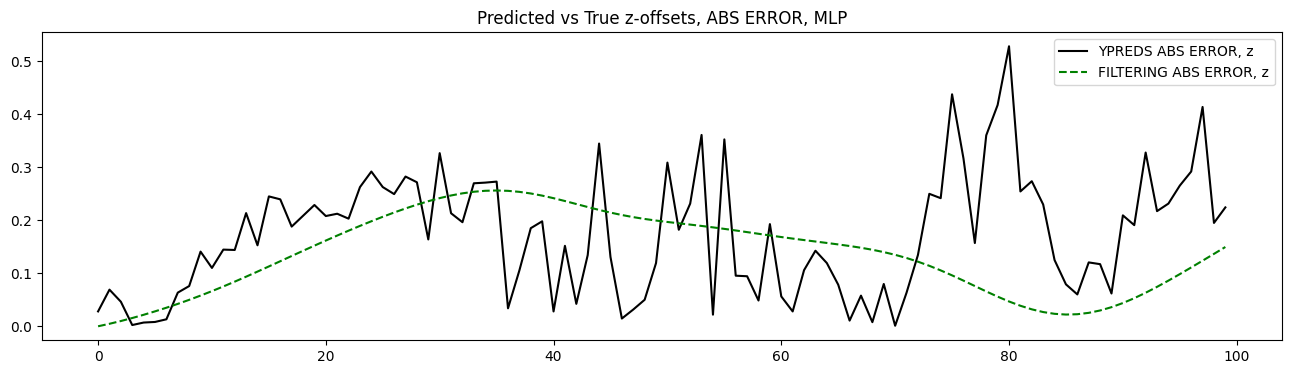

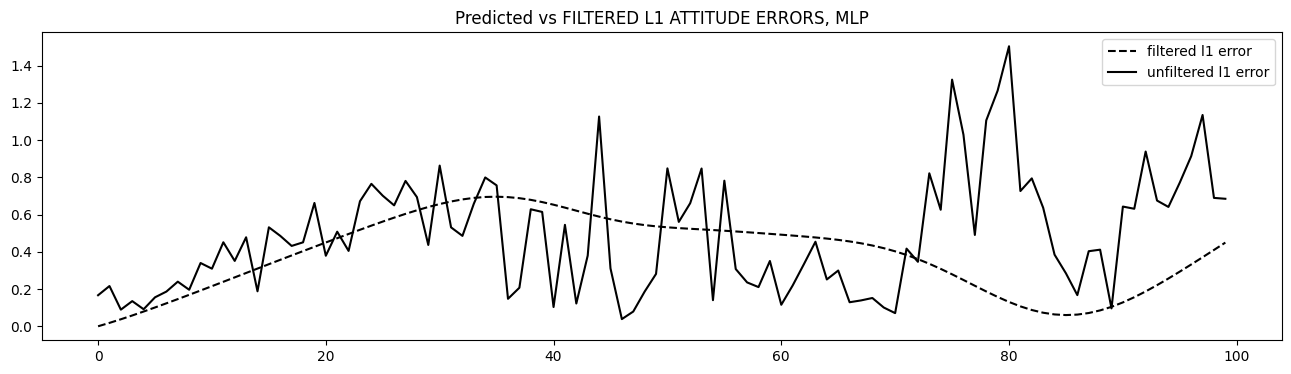

In [111]:
## EQUATIONS

def xhat_next_pred(xhat, xdothat, dt):
    xhat_next = xhat + dt * xdothat
    return xhat_next

def xdothat_next_pred(xdothat):
    xdothat_next = xdothat
    return xdothat_next

def xhat_next_meas(xhat_next, alpha, z_n):
    return xhat_next + alpha * (z_n - xhat_next)

def xdothat_next_meas(xdothat_next, beta, z_n, dt, xhat_next):
    return xdothat_next + beta * (z_n - xhat_next)/dt


def find_next(xhat, xdothat, z_n, timestep, dt, alpha, beta):
    xhat_10 = xhat_next_pred(xhat, xdothat, dt)
    xdothat_10 = xdothat_next_pred(xdothat)
    xhat_11 = xhat_next_meas(xhat_10, alpha, z_n[timestep])
    xdothat_11 = xdothat_next_meas(xdothat_10, beta, z_n[timestep], dt, xhat_10)
    xhat_next = xhat_11
    xdothat_next = xdothat_11
    return xhat_next, xdothat_next


# HYPERPARAMETERS

dt = 1
# alpha = 0.25
alpha=0.05
beta = 0.0001

xhat_00 = np.array([0, 0, 0])              # initial position guesses
xdothat_00 = np.array([0.01, 0.01, 0.01])   # initial velocity guesses


# PREDICTIONS
xvals_seq, y_vals_seq = load_data(path="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_sequence1_FORFILTERING1/data", attribute='attitude', spline=True)

key = 'MLP'
MODEL = ESTIMATORS[key]
YPREDS = MODEL.predict(scaler.transform(xvals_seq)) # 'measurements'
YTRUES = y_vals_seq
z_n = YPREDS


# smooth the predictions
from scipy.ndimage import gaussian_filter1d
z_n = np.array(
    list(
        zip(
            gaussian_filter1d(z_n[:,0], sigma=5), 
            gaussian_filter1d(z_n[:,1], sigma=5), 
            gaussian_filter1d(z_n[:,2], sigma=5)
        )
    )
)

xhat_now = xhat_00
xdothat_now = xdothat_00

xhats = [xhat_now]
xs = []
xdothats = [xdothat_now]

for timestep in range(len(z_n)-1):
    xhat_now, xdothat_now = find_next(xhat_now, xdothat_now, z_n, timestep, dt, alpha, beta)
    xhats.append(xhat_now)
    xdothats.append(xdothat_now)
    xs.append(YTRUES[timestep])

xhats = xhats[:-1]
xdothats = xdothats[:-1]
xs = xs
YPREDS = YPREDS[:-1]


plt.figure(figsize=(16, 4))
plt.title(f'Predicted vs True offsets, {key}')
plt.plot(np.array(YPREDS)[:,0], label='YPREDS, x', linestyle='solid', color='red')
plt.plot(np.array(YPREDS)[:,1], label='YPREDS, y', linestyle='solid', color='blue')
plt.plot(np.array(YPREDS)[:,2], label='YPREDS, z', linestyle='solid', color='green')
plt.plot(np.array(xhats)[:,0], label='FILTEREDPREDS x', linestyle='--', color='red', )
plt.plot(np.array(xs)[:,0], label='xTRUE', color='purple', linestyle='dotted')
plt.plot(np.array(xhats)[:,1], label='FILTEREDPREDS y', linestyle='--', color='blue')
plt.plot(np.array(xs)[:,1], label='yTRUE', color='purple', linestyle='dotted')
plt.plot(np.array(xhats)[:,2], label='FILTEREDPREDS z', linestyle='--', color='green')
plt.plot(np.array(xs)[:,2], label='zTRUE', color='purple', linestyle='dotted')
plt.legend()
plt.show()


def lp(true, pred, p):
    return np.linalg.norm(true - pred, axis=-1, ord=p)


# plot L2 distance between filtered and unfiltered predictions
plt.figure(figsize=(16, 4))
plt.title(f'Predicted vs True x-offsets, ABS ERROR, {key}')
plt.plot(np.abs(np.array(YPREDS)[:,0] - np.array(xs)[:,0])*180/np.pi, label='YPREDS ABS ERROR, x', linestyle='solid', color='black')
plt.plot(np.abs(np.array(xhats)[:,0] - np.array(xs)[:,0])*180/np.pi, label='FILTERING ABS ERROR, x', linestyle='--', color='green')
plt.legend()
plt.show()


plt.figure(figsize=(16, 4))
plt.title(f'Predicted vs True y-offsets, ABS ERROR, {key}')
plt.plot(np.abs(np.array(YPREDS)[:,1] - np.array(xs)[:,1]), label='YPREDS ABS ERROR, y', linestyle='solid', color='black')
plt.plot(np.abs(np.array(xhats)[:,1] - np.array(xs)[:,1]), label='FILTERING ABS ERROR, y', linestyle='--', color='green')
plt.legend()
plt.show()

plt.figure(figsize=(16, 4))
plt.title(f'Predicted vs True z-offsets, ABS ERROR, {key}')
plt.plot(np.abs(np.array(YPREDS)[:,2] - np.array(xs)[:,2]), label='YPREDS ABS ERROR, z', linestyle='solid', color='black')
plt.plot(np.abs(np.array(xhats)[:,2] - np.array(xs)[:,2]), label='FILTERING ABS ERROR, z', linestyle='--', color='green')
plt.legend()
plt.show()

plt.figure(figsize=(16, 4))
plt.title(f'Predicted vs FILTERED L1 ATTITUDE ERRORS, {key}')
plt.plot(lp(np.array(xhats), np.array(xs), 1), label='filtered l1 error', linestyle='--', color='black')
plt.plot(lp(np.array(YPREDS), np.array(xs), 1), label='unfiltered l1 error', linestyle='solid', color='black')
plt.legend()
plt.show()


loading x vals: 100%|██████████| 101/101 [00:01<00:00, 53.55it/s]


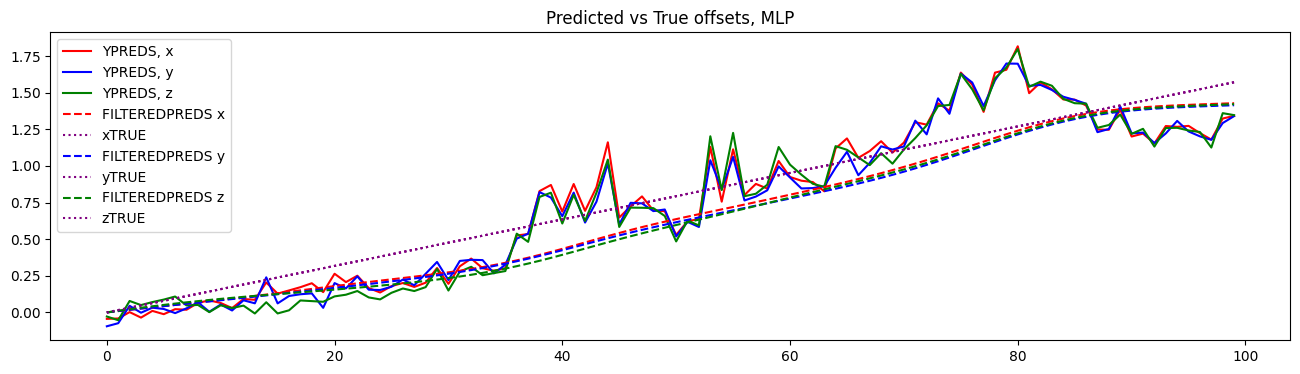

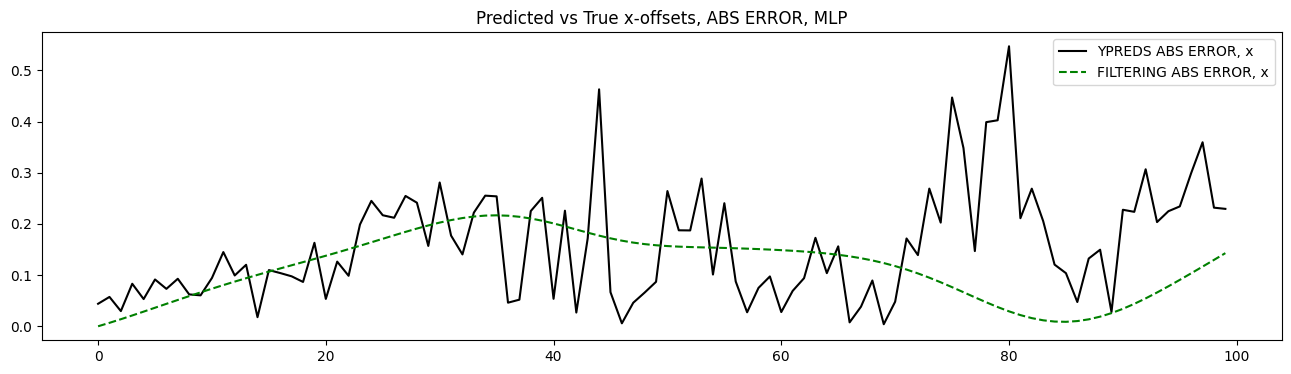

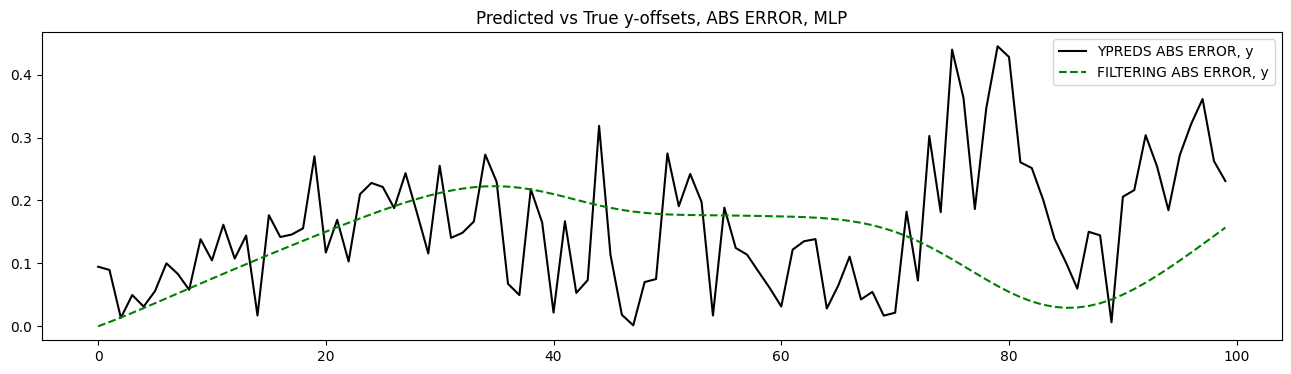

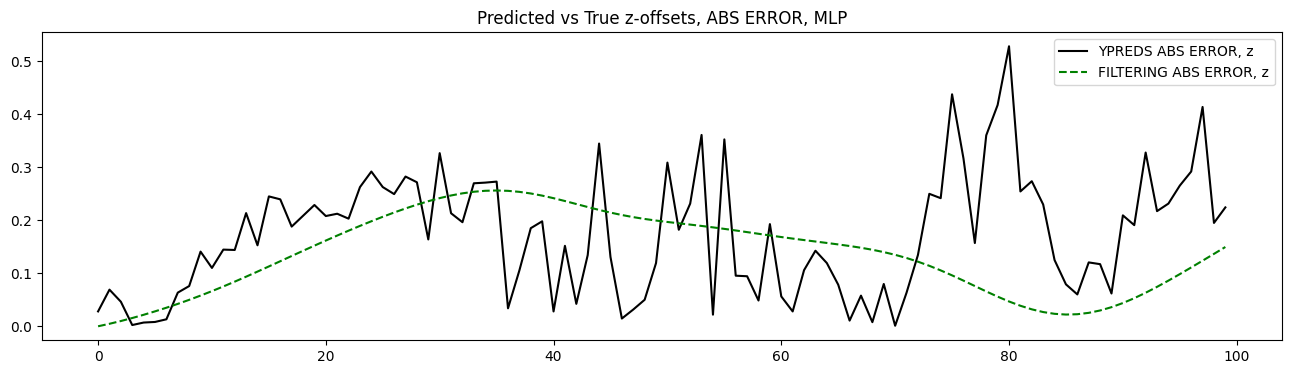

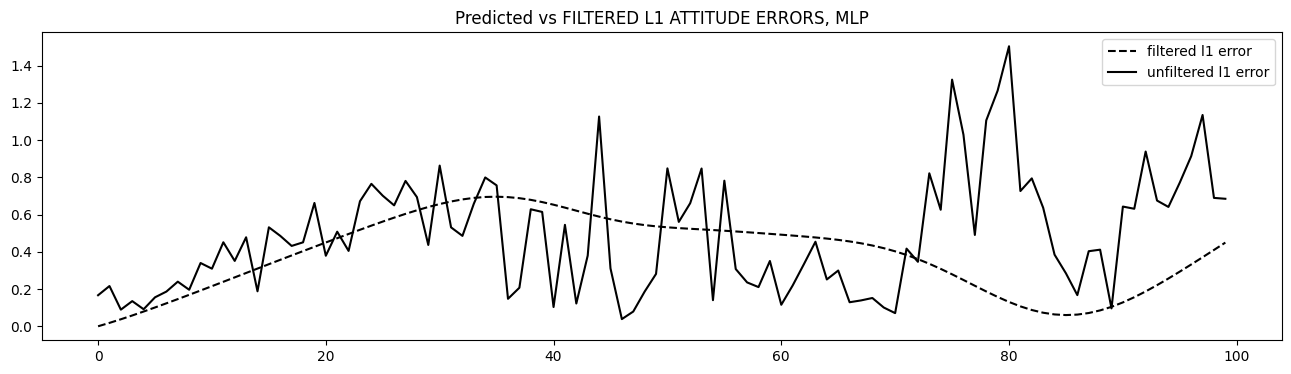

In [110]:

## EQUATIONS

def xhat_next_pred(xhat, xdothat, dt):
    xhat_next = xhat + dt * xdothat
    return xhat_next

def xdothat_next_pred(xdothat):
    xdothat_next = xdothat
    return xdothat_next

def xhat_next_meas(xhat_next, alpha, z_n):
    return xhat_next + alpha * (z_n - xhat_next)

def xdothat_next_meas(xdothat_next, beta, z_n, dt, xhat_next):
    return xdothat_next + beta * (z_n - xhat_next)/dt


def find_next(xhat, xdothat, z_n, timestep, dt, alpha, beta):
    xhat_10 = xhat_next_pred(xhat, xdothat, dt)
    xdothat_10 = xdothat_next_pred(xdothat)
    xhat_11 = xhat_next_meas(xhat_10, alpha, z_n[timestep])
    xdothat_11 = xdothat_next_meas(xdothat_10, beta, z_n[timestep], dt, xhat_10)
    xhat_next = xhat_11
    xdothat_next = xdothat_11
    return xhat_next, xdothat_next


# HYPERPARAMETERS
dt = 1
# alpha = 0.25
alpha=0.05
beta = 0.0001

xhat_00 = np.array([0, 0, 0])              # initial position guesses
xdothat_00 = np.array([0.01, 0.01, 0.01])   # initial velocity guesses


# PREDICTIONS
xvals_seq, y_vals_seq = load_data(path="/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_sequence1_FORFILTERING1/data", attribute='attitude', spline=True)

key = 'MLP'
MODEL = ESTIMATORS[key]
YPREDS = MODEL.predict(scaler.transform(xvals_seq)) # 'measurements'
YTRUES = y_vals_seq
z_n = YPREDS


# smooth the predictions
from scipy.ndimage import gaussian_filter1d
z_n = np.array(
    list(
        zip(
            gaussian_filter1d(z_n[:,0], sigma=5), 
            gaussian_filter1d(z_n[:,1], sigma=5), 
            gaussian_filter1d(z_n[:,2], sigma=5)
        )
    )
)

xhat_now = xhat_00
xdothat_now = xdothat_00

xhats = [xhat_now]
xs = []
xdothats = [xdothat_now]

for timestep in range(len(z_n)-1):
    xhat_now, xdothat_now = find_next(xhat_now, xdothat_now, z_n, timestep, dt, alpha, beta)
    xhats.append(xhat_now)
    xdothats.append(xdothat_now)
    xs.append(YTRUES[timestep])

xhats = xhats[:-1]
xdothats = xdothats[:-1]
xs = xs
YPREDS = YPREDS[:-1]


plt.figure(figsize=(16, 4))
plt.title(f'Predicted vs True offsets, {key}')
plt.plot(np.array(YPREDS)[:,0], label='YPREDS, x', linestyle='solid', color='red')
plt.plot(np.array(YPREDS)[:,1], label='YPREDS, y', linestyle='solid', color='blue')
plt.plot(np.array(YPREDS)[:,2], label='YPREDS, z', linestyle='solid', color='green')
plt.plot(np.array(xhats)[:,0], label='FILTEREDPREDS x', linestyle='--', color='red', )
plt.plot(np.array(xs)[:,0], label='xTRUE', color='purple', linestyle='dotted')
plt.plot(np.array(xhats)[:,1], label='FILTEREDPREDS y', linestyle='--', color='blue')
plt.plot(np.array(xs)[:,1], label='yTRUE', color='purple', linestyle='dotted')
plt.plot(np.array(xhats)[:,2], label='FILTEREDPREDS z', linestyle='--', color='green')
plt.plot(np.array(xs)[:,2], label='zTRUE', color='purple', linestyle='dotted')
plt.legend()
plt.show()


def lp(true, pred, p):
    return np.linalg.norm(true - pred, axis=-1, ord=p)


# plot L2 distance between filtered and unfiltered predictions
plt.figure(figsize=(16, 4))
plt.title(f'Predicted vs True x-offsets, ABS ERROR, {key}')
plt.plot(np.abs(np.array(YPREDS)[:,0] - np.array(xs)[:,0]), label='YPREDS ABS ERROR, x', linestyle='solid', color='black')
plt.plot(np.abs(np.array(xhats)[:,0] - np.array(xs)[:,0]), label='FILTERING ABS ERROR, x', linestyle='--', color='green')
plt.legend()
plt.show()


plt.figure(figsize=(16, 4))
plt.title(f'Predicted vs True y-offsets, ABS ERROR, {key}')
plt.plot(np.abs(np.array(YPREDS)[:,1] - np.array(xs)[:,1]), label='YPREDS ABS ERROR, y', linestyle='solid', color='black')
plt.plot(np.abs(np.array(xhats)[:,1] - np.array(xs)[:,1]), label='FILTERING ABS ERROR, y', linestyle='--', color='green')
plt.legend()
plt.show()

plt.figure(figsize=(16, 4))
plt.title(f'Predicted vs True z-offsets, ABS ERROR, {key}')
plt.plot(np.abs(np.array(YPREDS)[:,2] - np.array(xs)[:,2]), label='YPREDS ABS ERROR, z', linestyle='solid', color='black')
plt.plot(np.abs(np.array(xhats)[:,2] - np.array(xs)[:,2]), label='FILTERING ABS ERROR, z', linestyle='--', color='green')
plt.legend()
plt.show()

plt.figure(figsize=(16, 4))
plt.title(f'Predicted vs FILTERED L1 ATTITUDE ERRORS, {key}')
plt.plot(lp(np.array(xhats), np.array(xs), 1), label='filtered l1 error', linestyle='--', color='black')
plt.plot(lp(np.array(YPREDS), np.array(xs), 1), label='unfiltered l1 error', linestyle='solid', color='black')
plt.legend()
plt.show()
